In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import itertools
import os

import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import teotil3 as teo
from tqdm.notebook import tqdm

plt.style.use("ggplot")

# TEOTIL3 Trondheimsfjorden

# Part 7: Run model

In [3]:
nve_data_year = 2024
st_yr, end_yr = 2013, 2023
input_data_fold = r"/home/jovyan/shared/common/teotil3/trondheimsfjorden_scenarios/teotil3_input_files"
result_csv = f"/home/jovyan/shared/common/teotil3/trondheimsfjorden_scenarios/trondheimsfjorden_results_nve{nve_data_year}_{st_yr}-{end_yr}.csv"

# Vassdragsområder draining to Trondheimsfjorden
vassoms = range(120, 133)

# Scenarios from NIBIO
scen_list = [
    "Baseline",
    "SC1",
    "SC2",
    "SC4",
    "SC5",
    "SC6",
    "SC7a",
    "SC7b",
    "SC8",
    "SC9",
    "AV1",
    "AV2",
    "AV3",
    "AV4",
]

## 1. Run TEOTIL3

In [4]:
# Run TEOTIL3
df_list = []
years = range(st_yr, end_yr + 1)
for scen in scen_list:
    print("Processing:", scen)
    for year in years:
        csv_path = os.path.join(
            input_data_fold,
            scen,
            f"trondheimsfjorden_input_data_scen-{scen.lower()}_nve{nve_data_year}_{year}.csv",
        )
        g = teo.model.run_model(
            csv_path,
            id_col="regine",
            next_down_col="regine_down",
            totals_from_subfracs=True,
        )
        res_df = teo.model.model_to_dataframe(
            g, id_col="regine", next_down_col="regine_down"
        )
        res_df["scenario"] = scen
        res_df["year"] = year
        df_list.append(res_df)
mod_df = pd.concat(df_list, axis="rows")
id_cols = ["scenario", "year", "regine", "regine_down"]
cols = [col for col in mod_df.columns if col not in id_cols]
mod_df = mod_df[id_cols + cols]
mod_df.to_csv(result_csv, index=False)

Processing: Baseline
Processing: SC1
Processing: SC2
Processing: SC4
Processing: SC5
Processing: SC6
Processing: SC7a
Processing: SC7b
Processing: SC8
Processing: SC9
Processing: AV1
Processing: AV2
Processing: AV3
Processing: AV4


In [5]:
# Read saved data for speed
mod_df = pd.read_csv(result_csv)
mod_df.head()

,scenario,year,regine,regine_down,accum_agriculture-background_din_kg,accum_agriculture-background_ss_kg,accum_agriculture-background_tdp_kg,accum_agriculture-background_toc_kg,accum_agriculture-background_ton_kg,accum_agriculture-background_totn_kg,...,local_urban_totp_kg,local_urban_tpp_kg,local_wood_din_kg,local_wood_ss_kg,local_wood_tdp_kg,local_wood_toc_kg,local_wood_ton_kg,local_wood_totn_kg,local_wood_totp_kg,local_wood_tpp_kg
0,Baseline,2013,120.111,120.,294.041409,4724.995038,3.341540,7364.350432,75.858338,369.899747,...,29.0,11.6,123.1,6148.3,5.8,56685.2,1047.0,1170.1,33.4,27.6
1,Baseline,2013,120.1120,120.,105.272947,1936.771554,1.311753,2638.932168,29.436172,134.709119,...,1.8,0.7,26.2,1295.5,1.2,11962.9,224.8,251.0,7.1,5.9
2,Baseline,2013,120.112Z,120.,69.306927,91.185524,0.631110,1506.976561,19.288438,88.595366,...,0.0,0.0,60.0,2719.9,2.8,27274.7,511.1,571.1,16.3,13.5
3,Baseline,2013,120.11Z,120.,28.594557,18.969073,1.079797,1769.637270,10.153382,38.747939,...,0.0,0.0,158.4,6800.2,7.5,71711.6,1341.9,1500.3,43.0,35.5
4,Baseline,2013,120.12,120.,112.728112,1903.222957,1.298166,2577.829957,29.549642,142.277754,...,0.0,0.0,88.7,4250.9,4.2,39773.3,758.2,846.9,24.6,20.4


## 2. Sense check new baseline against original baseline

**Update 24.11.2024:** These should now be identical, as NIBIO have updated the national baseline.

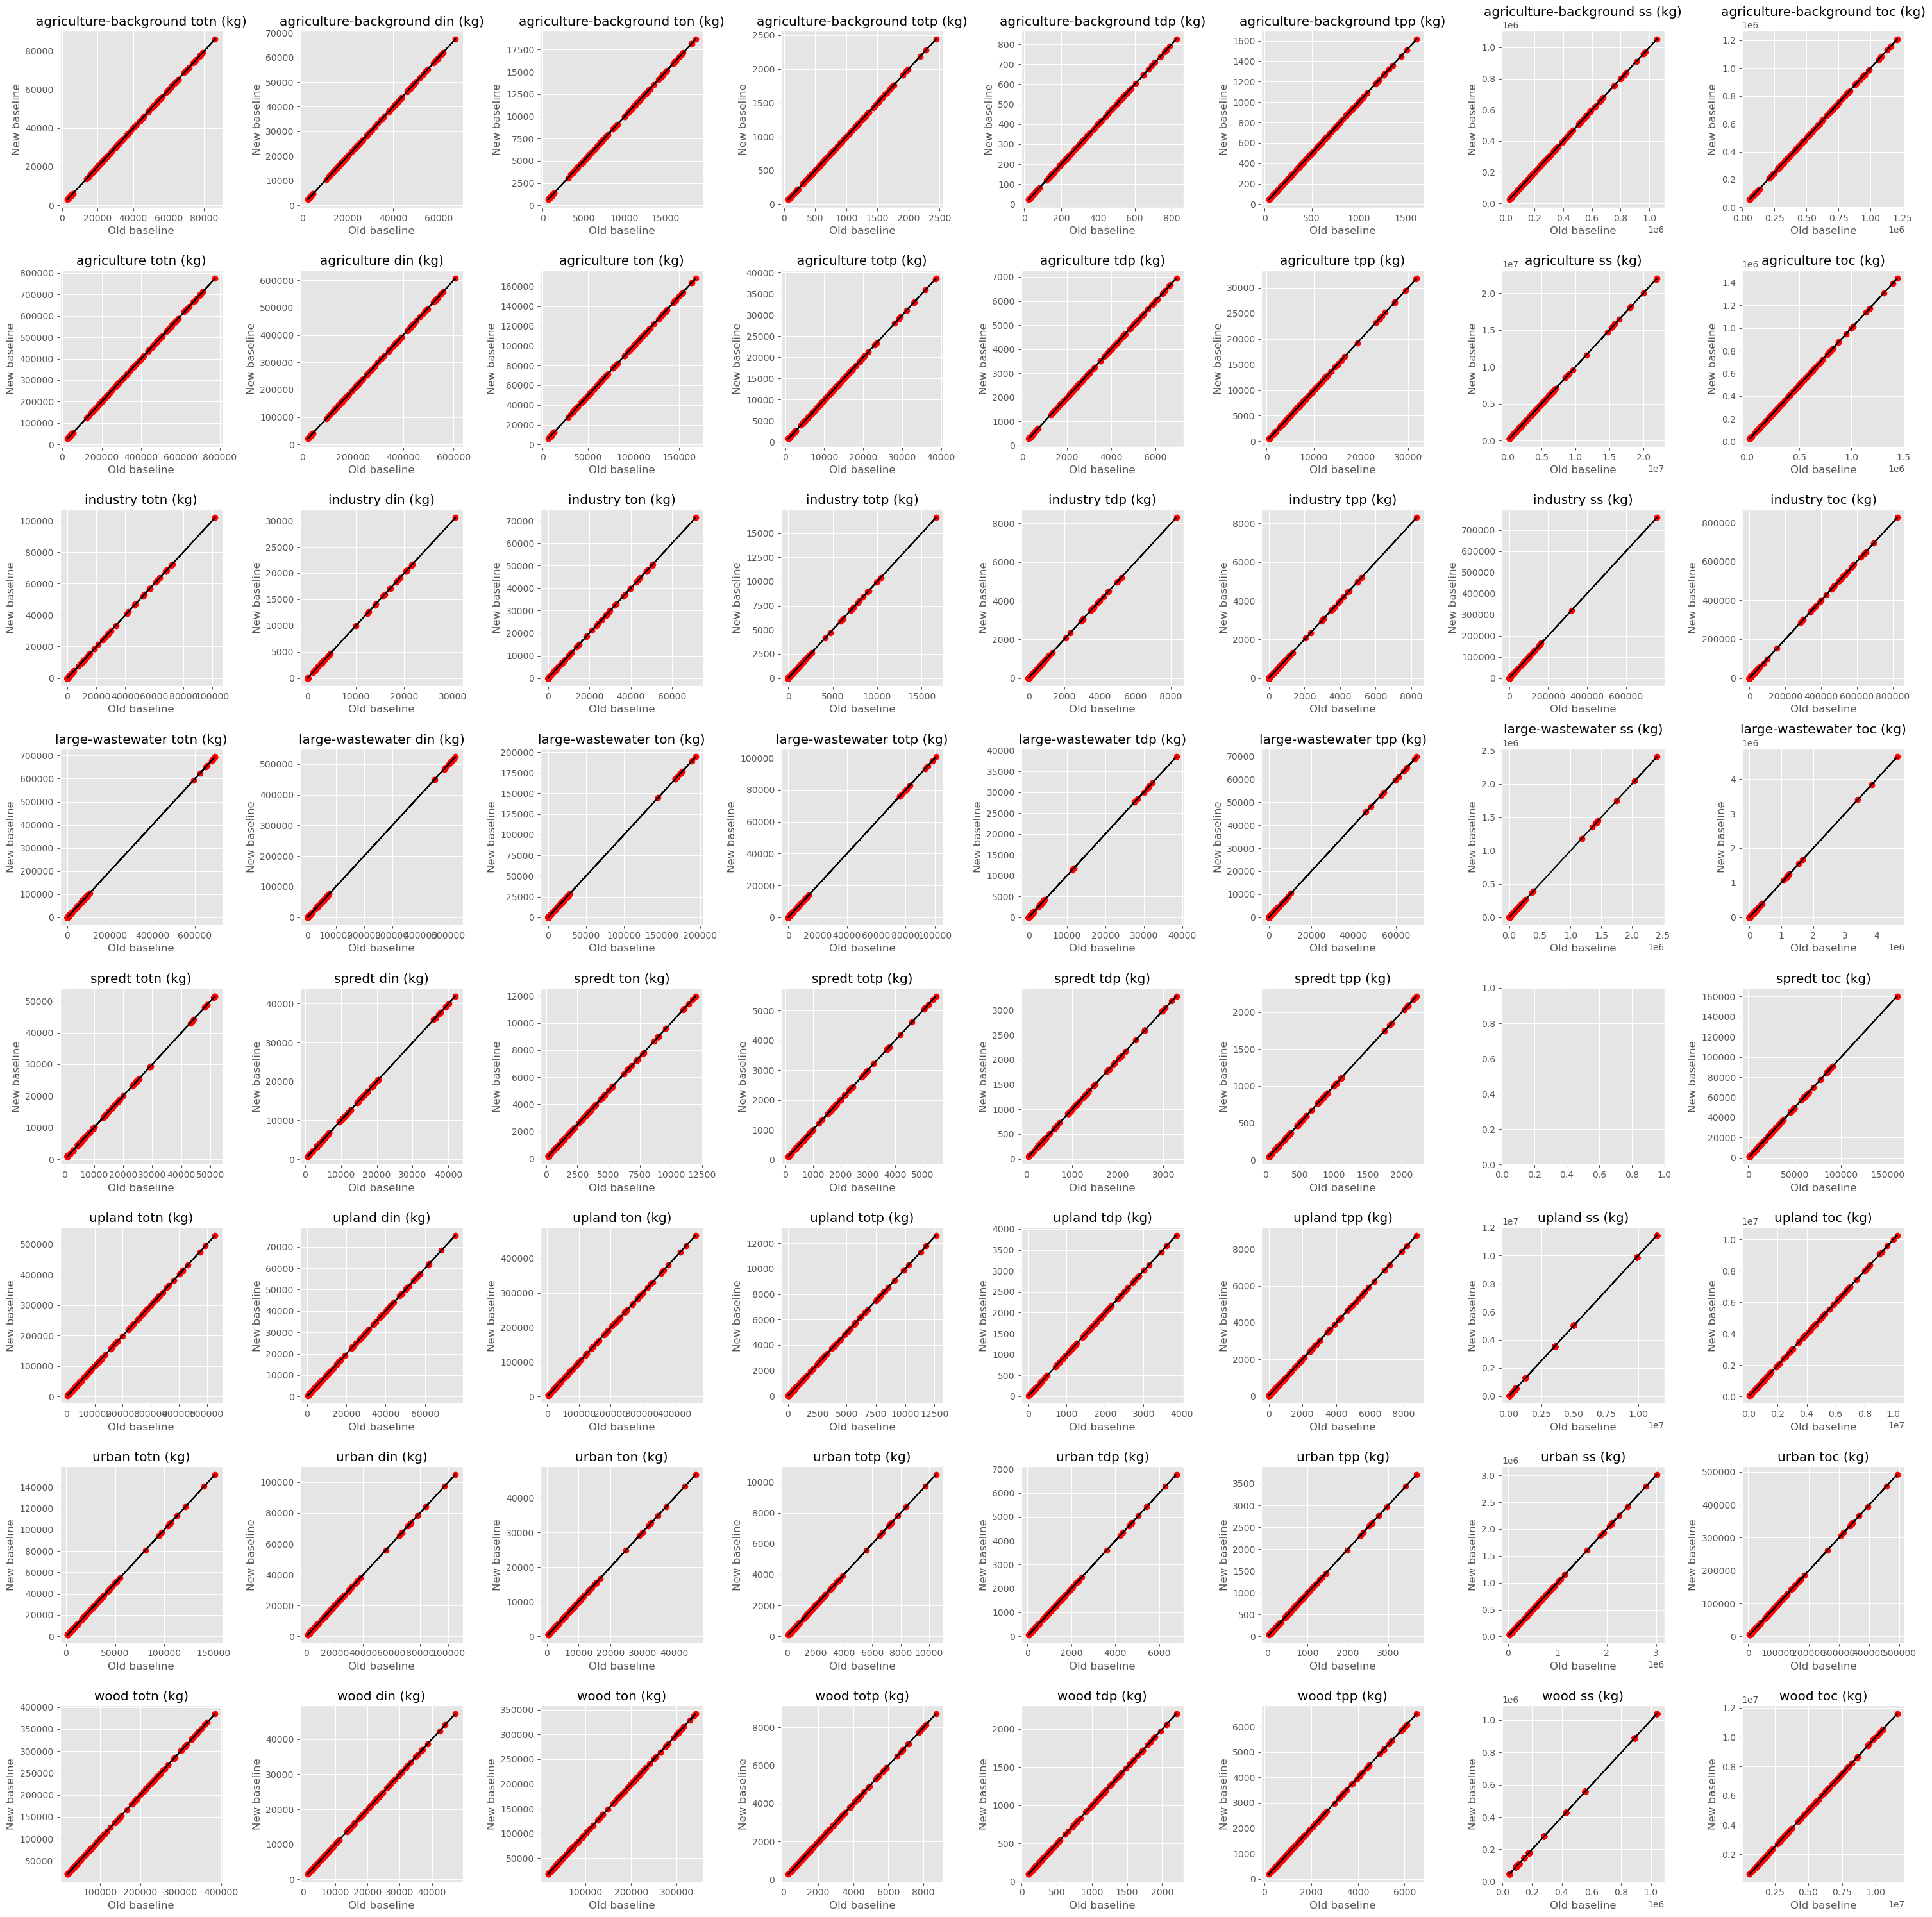

In [6]:
# Read TEOTIL3 results using original baseline
orig_csv = f"/home/jovyan/shared/common/teotil3/evaluation/teo3_results_nve{nve_data_year}_{st_yr}-{end_yr}_agri-annual-loss.csv"
orig_df = pd.read_csv(orig_csv)

# Filter to main vassdragsområder of interest
vassom_list = [f"{vassom:03d}." for vassom in vassoms]
orig_df = orig_df.query("regine in @vassom_list").reset_index(drop=True)

# Get results using new baseline
new_df = mod_df.query("(scenario == 'Baseline') and (regine in @vassom_list)").copy()

# Get cols of interest
acc_cols = [col for col in new_df.columns if col.startswith("accum_")]
id_cols = ["year", "regine"]
orig_df = orig_df[id_cols + acc_cols]
new_df = new_df[id_cols + acc_cols]

# Join
comp_df = pd.merge(
    orig_df, new_df, how="left", on=["year", "regine"], suffixes=("_old", "_new")
)

# Compare
pars = ["totn", "din", "ton", "totp", "tdp", "tpp", "ss", "toc"]
srcs = [
    "agriculture-background",
    "agriculture",
    "industry",
    "large-wastewater",
    "spredt",
    "upland",
    "urban",
    "wood",
]
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(30, 30))
for col_idx, par in enumerate(pars):
    for row_idx, src in enumerate(srcs):
        title = f"{src} {par} (kg)"
        old_name = f"accum_{src}_{par}_kg_old"
        new_name = f"accum_{src}_{par}_kg_new"
        if old_name in comp_df.columns:
            axes[row_idx, col_idx].plot(comp_df[old_name], comp_df[new_name], "ro")
            axes[row_idx, col_idx].plot(comp_df[old_name], comp_df[old_name], "k-")
            axes[row_idx, col_idx].set_title(title)
            axes[row_idx, col_idx].set_xlabel("Old baseline")
            axes[row_idx, col_idx].set_ylabel("New baseline")
plt.tight_layout()